# Determining Clients' Age
(computer vision)

## Content
1. [Introduction](#intro)
1. [Get Data](#getdata)
2. [Model](#model)
2. [Analyze](#ana)
3. [Conclusion](#conc)

## Introduction<a href='intro'></a>
*Project Description*

Supermarket chain Good Seed is introducing a computer vision system for processing customer photos. Photofixation in the checkout area will help determine the age of customers in order to:
- Analyze purchases and offer products that may interest buyers in particular age groups
- Monitor clerks selling alcohol

Build a model that will determine the approximate age of a person from a photograph. To help, you'll have a set of photographs of people with their ages indicated.

## Get Data<a href='getdata'></a>

In [3]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dense, AvgPool2D, Flatten, MaxPool2D

from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [4]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [5]:
labels.sample(10, random_state=123456)

,file_name,real_age
2101,002101.jpg,19
2898,002898.jpg,24
7413,007435.jpg,30
2011,002011.jpg,23
2422,002422.jpg,29
529,000529.jpg,2
2353,002353.jpg,55
5464,005464.jpg,42
5101,005101.jpg,16
7309,007331.jpg,34


In [6]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [7]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [8]:
train_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [10]:
features, target = next(train_gen_flow)

In [11]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

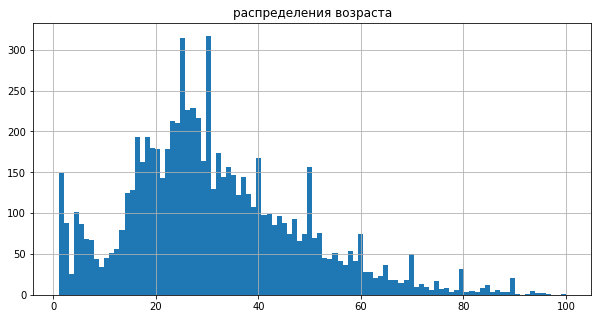

In [12]:
graf = labels['real_age'].hist(bins=100, figsize=(10,5))
graf.set_title('распределения возраста')
plt.show()

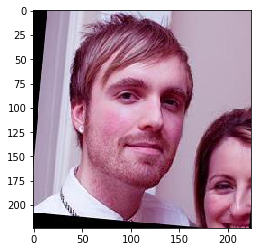

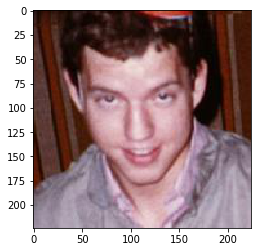

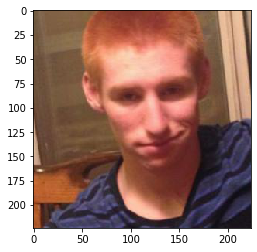

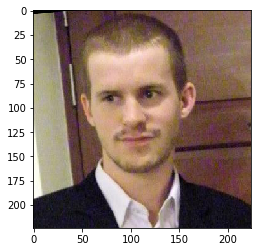

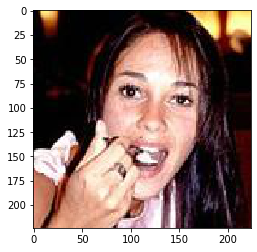

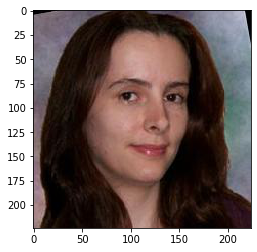

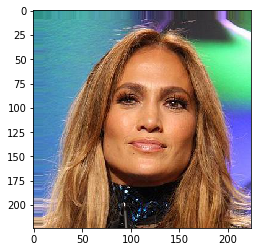

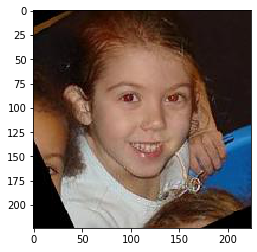

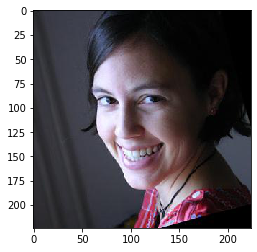

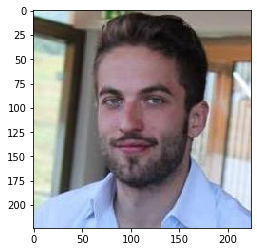

In [14]:
for i in range(10):
    a = random.randint(0, len(next(train_gen_flow))) 
    plt.imshow(np.array(next(train_gen_flow)[0][a]))
#     plt.title("real_age")
    plt.show()

### Conclusion

1. We have dataset of 7591 imag. 
2. Min age 1 year, max - 100. 
3. We have not good photos for learning: rotated, pixeled, can't see clear faces, etc. We can make photo blac/white.
4. We can see a lot of peaks. In general we can cut from data photos with babys, toddlers etc on it. they don't buy anything. Also we can see that from around 50/60 years amount of photos is decreasing. Here can be such reason as not so many people in this age and older are registed on platforms to upload photos.
5. Also we have photos with two people on it.

## Model<a href='model'></a>

<div class="alert alert-warning">
<b>Комментарий ревьюера</b>

В данном разделе мы только копируем код из тренажера. Чтобы ячейке Markdown код отображался как код, я добавил специальные символы.
</div>

```python
def load_test(path=None):
    labels = pd.read_csv('/datasets/faces/labels.csv')

    datagen_test = ImageDataGenerator(rescale=(1.0/255.0), validation_split=0.2)

    test_datagen_flow = datagen_test.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_datagen_flow
```

```python
def load_train(path=None):
    labels = pd.read_csv('/datasets/faces/labels.csv')

    datagen_train = ImageDataGenerator(rescale=(1.0/255.0), validation_split=0.2, rotation_range=15,
                                  width_shift_range=0.2, height_shift_range=0.2)

    train_datagen_flow = datagen_train.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow
```

```python
def create_model(input_shape):
    optimizer = Adam(learning_rate = 0.0003)

    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='linear'))

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model
```

```python
def train_model(model, train_datagen_flow, val_datagen_flow, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch == None:
        steps_per_epoch = len(train_datagen_flow)
    if validation_steps == None:
        validation_steps = len(val_datagen_flow)

    model.fit(train_datagen_flow,
              validation_data=val_datagen_flow,
              steps_per_epoch=steps_per_epoch,
              epochs=epochs,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model
```

## Analyze<a href='ana'></a>

1. MAE on test set is about 7 years.
2. According to the results we can use 15 epochs.
3. Learning_rate is 0.0003.
4. Learning takes around one our

## Conclusion<a href='conc'></a>

Mae = 7 years is a big amount. Here we can group visitors by age. If we talk about people 20-27 years old - there is not so big difference in appearance, but if we talk about age 11-15 or 15-20 here can be differences which model can't understand and give us a mistake. Plus we have people who looks younger and older. This should be a reason for mae amount.